In [1]:
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, coo_matrix, triu
from incremental_coo_matrix import IncrementalCOOMatrix

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
threshold = 0.40

# Methods

In [3]:
def read_embedding(embedding_file_path, binary):
    model = KeyedVectors.load_word2vec_format(embedding_file_path, binary=binary)
    return model

In [4]:
def read_raw_dataset(document_path):
    arq = open(document_path, 'r', encoding="utf-8")
    doc = arq.readlines()
    arq.close()
    documents = list(map(str.rstrip, doc))
    return documents

In [5]:
def load_vocabulary(documents):
    # Count the words in dataset
    dataset_cv = CountVectorizer().fit(documents)
    vocabulary = dataset_cv.get_feature_names()
    return vocabulary

In [6]:
def filter_embedding_models(vocabulary, model, dimension):
    vocabulary_embedding = list()
    word_vectors = list()
    
    for word in vocabulary:
        if word in model:
            vocabulary_embedding.append(word)
            word_vectors.append(np.asarray(model[word], dtype=np.float64))

    n_words = len(vocabulary_embedding)  # Number of words selected

    return np.asarray(word_vectors), np.sort(np.asarray(vocabulary_embedding)), n_words

In [7]:
def build_word_vector_matrix(words_values, n_words):
    numpy_arrays = list()
    labels_array = list()

    for r in words_values:
        sr = r.split()
        labels_array.append(sr[0])
        numpy_arrays.append(np.array([float(i) for i in sr[1:]]))

    return np.array(numpy_arrays), np.asarray(labels_array)

In [8]:
def create_cosine_matrix(word_vectors, 
                         vocabulary_embedding):
    cosine_matrix = triu(cosine_similarity(word_vectors, word_vectors))
    return cosine_matrix

# Dataset face

In [9]:
document_path = ""

## FastText embedding

In [10]:
embedding_file_path = ""
model = read_embedding(embedding_file_path=embedding_file_path, 
                       binary=False)
documents = read_raw_dataset(document_path)
vocabulary = load_vocabulary(documents)
word_vectors, vocabulary_embedding, n_words = filter_embedding_models(vocabulary=vocabulary, model=model, dimension=300)

## k-NN

In [11]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=len(vocabulary_embedding),
                                algorithm='auto',
                                metric='cosine',
                                n_jobs=4).fit(word_vectors)

In [12]:
distances, indices = nbrs.kneighbors(word_vectors)

In [13]:
list_cluwords_knn = IncrementalCOOMatrix(shape=(n_words, n_words), dtype=np.float32)

In [14]:
for word_ref_index in range(0, n_words):
    for index, k in enumerate(indices[word_ref_index]):
        if 1 - distances[word_ref_index][index] >= threshold:
            list_cluwords_knn.append(word_ref_index, k, round(1. - distances[word_ref_index][index], 2))

In [15]:
knn = list_cluwords_knn.tocsr().todense()

## Plot Distribution

In [26]:
import seaborn as sns

def plot_dist(cosine_matrix):
    cosine_vec = cosine_matrix.flatten()

    sns.set_theme()
    ax = sns.distplot(cosine_vec)
    return

### kNN

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


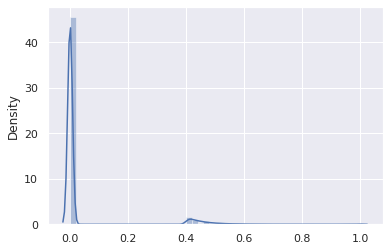

In [27]:
plot_dist(cosine_matrix=knn)